# ปีเตอร์กับหมาป่า: สภาพแวดล้อมที่สมจริง

ในสถานการณ์ของเรา ปีเตอร์สามารถเคลื่อนที่ไปมาได้เกือบจะโดยไม่รู้สึกเหนื่อยหรือหิวเลย ในโลกที่สมจริงมากขึ้น เขาจะต้องนั่งพักและพักผ่อนเป็นครั้งคราว รวมถึงต้องหาอาหารกินด้วย มาเพิ่มความสมจริงให้โลกของเราด้วยการนำกฎเหล่านี้มาใช้:

1. เมื่อเคลื่อนที่จากที่หนึ่งไปยังอีกที่หนึ่ง ปีเตอร์จะสูญเสีย **พลังงาน** และเพิ่ม **ความเหนื่อยล้า** ขึ้น
2. ปีเตอร์สามารถเพิ่มพลังงานได้โดยการกินแอปเปิ้ล
3. ปีเตอร์สามารถลดความเหนื่อยล้าได้โดยการพักผ่อนใต้ต้นไม้หรือบนพื้นหญ้า (เช่น เดินไปยังตำแหน่งที่มีต้นไม้หรือหญ้า - พื้นที่สีเขียว)
4. ปีเตอร์ต้องค้นหาและกำจัดหมาป่า
5. เพื่อที่จะกำจัดหมาป่า ปีเตอร์จำเป็นต้องมีระดับพลังงานและความเหนื่อยล้าในระดับที่เหมาะสม มิฉะนั้นเขาจะพ่ายแพ้ในการต่อสู้


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

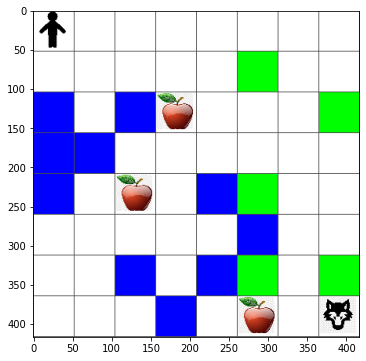

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## การกำหนดสถานะ

ในกฎของเกมใหม่ เราจำเป็นต้องติดตามพลังงานและความเหนื่อยล้าในแต่ละสถานะของกระดาน ดังนั้นเราจะสร้างออบเจกต์ `state` ที่จะเก็บข้อมูลทั้งหมดที่จำเป็นเกี่ยวกับสถานะปัจจุบันของปัญหา รวมถึงสถานะของกระดาน ระดับพลังงานและความเหนื่อยล้าในปัจจุบัน และความเป็นไปได้ที่เราจะชนะหมาป่าเมื่ออยู่ในสถานะสุดท้าย:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## ฟังก์ชันรางวัล

### คำอธิบาย
ฟังก์ชันรางวัลเป็นส่วนสำคัญในการกำหนดพฤติกรรมของตัวแทนในระบบการเรียนรู้แบบเสริมกำลัง (Reinforcement Learning - RL) โดยฟังก์ชันนี้จะให้ค่าตอบแทนแก่ตัวแทนตามการกระทำที่เกิดขึ้นในสภาพแวดล้อม

### ตัวอย่าง
ตัวอย่างฟังก์ชันรางวัลที่เรียบง่าย:

```python
def reward_function(state, action):
    if state == "goal":
        return 1  # รางวัลสำหรับการบรรลุเป้าหมาย
    else:
        return 0  # ไม่มีรางวัลสำหรับสถานะอื่น
```

### หลักการออกแบบ
- **ความชัดเจน**: ฟังก์ชันรางวัลควรสะท้อนเป้าหมายของระบบอย่างชัดเจน
- **ความสมดุล**: หลีกเลี่ยงการให้รางวัลที่มากเกินไปหรือไม่เพียงพอ
- **ความสอดคล้อง**: รางวัลควรสอดคล้องกับพฤติกรรมที่ต้องการ

### ข้อควรระวัง
[!WARNING] การออกแบบฟังก์ชันรางวัลที่ไม่เหมาะสมอาจนำไปสู่พฤติกรรมที่ไม่คาดคิดของตัวแทน

### เคล็ดลับ
[!TIP] ทดสอบฟังก์ชันรางวัลในสถานการณ์จำลองก่อนใช้งานจริงเพื่อให้แน่ใจว่ามันทำงานตามที่คาดหวัง


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## อัลกอริทึม Q-Learning

อัลกอริทึมการเรียนรู้จริงๆ ยังคงเหมือนเดิม เพียงแค่เราใช้ `state` แทนที่จะใช้ตำแหน่งของกระดานเพียงอย่างเดียว


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

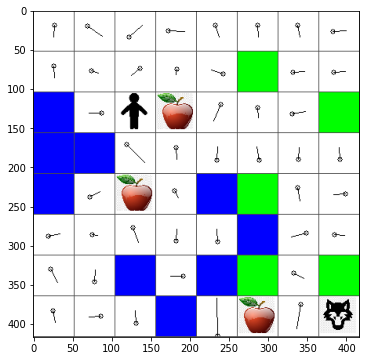

In [11]:
m.plot(Q)

## ผลลัพธ์

มาดูกันว่าเราสามารถฝึกปีเตอร์ให้ต่อสู้กับหมาป่าได้สำเร็จหรือไม่!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


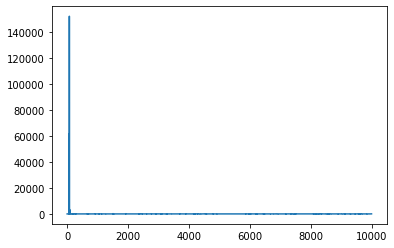

In [13]:
plt.plot(lpath)


---

**ข้อจำกัดความรับผิดชอบ**:  
เอกสารนี้ได้รับการแปลโดยใช้บริการแปลภาษา AI [Co-op Translator](https://github.com/Azure/co-op-translator) แม้ว่าเราจะพยายามให้การแปลมีความถูกต้องมากที่สุด แต่โปรดทราบว่าการแปลโดยอัตโนมัติอาจมีข้อผิดพลาดหรือความไม่ถูกต้อง เอกสารต้นฉบับในภาษาดั้งเดิมควรถือเป็นแหล่งข้อมูลที่เชื่อถือได้ สำหรับข้อมูลที่สำคัญ ขอแนะนำให้ใช้บริการแปลภาษามืออาชีพ เราไม่รับผิดชอบต่อความเข้าใจผิดหรือการตีความผิดที่เกิดจากการใช้การแปลนี้
